In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras.models import Model

In [ ]:
tf.random.set_seed(42)
N=1
# Device (GPU if available)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

### --- Synthetic Mini Data Generation --- ###
L, W = 1.0, 0.6  # Antenna dimensions (normalized)
sigma = 1.0       # Conductivity (simplified)
E0 = 10.0    

In [ ]:
x = np.linspace(0, L, 100, dtype=np.float32)  
y = np.linspace(0, W, 100, dtype=np.float32)
X, Y = np.meshgrid(x, y)
X_tensor = tf.convert_to_tensor(X.reshape(-1, 1), dtype=tf.float32)
Y_tensor = tf.convert_to_tensor(Y.reshape(-1, 1), dtype=tf.float32)
E_field = E0 * np.sin(np.pi * X / L) * np.sin(np.pi * Y / W)
E_field = E_field.astype(np.float32)
Q_rad = 0.5 * sigma * (E_field ** 2) 
Q_rad_tensor = tf.convert_to_tensor(Q_rad.reshape(-1, 1), dtype=tf.float32)

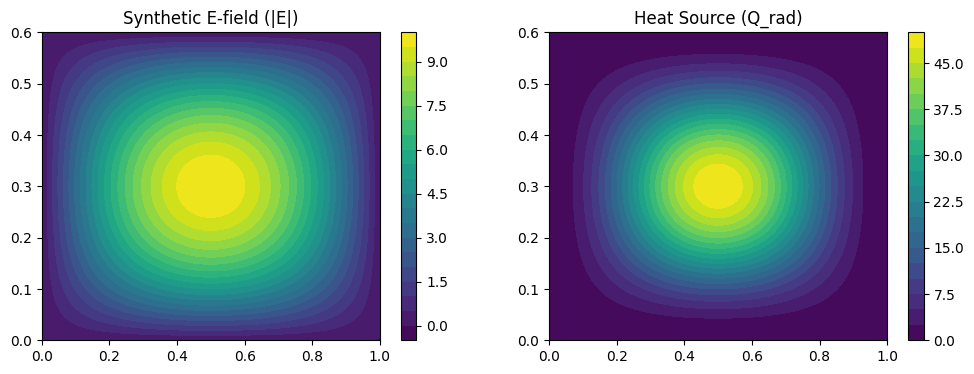

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.contourf(X, Y, E_field, levels=20)
plt.colorbar()
plt.title("Synthetic E-field (|E|)")

plt.subplot(122)
plt.contourf(X, Y, Q_rad, levels=20)
plt.colorbar()
plt.title("Heat Source (Q_rad)")
plt.show()

In [ ]:
inputs = Input(shape=(2,))
x = Dense(50, activation='tanh')(inputs)
x = Dense(50, activation='tanh')(x)
outputs = Dense(1)(x)
model = Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
# Loss Function
def compute_loss():
    with tf.GradientTape(persistent=True) as tape:
        # Collocation points
        tape.watch(X_tensor)
        tape.watch(Y_tensor)
        inputs = concatenate([X_tensor, Y_tensor], axis=1)
        T = model(inputs)
        T = tf.reshape(T, (N, N))
        grad_T = tape.gradient(T, [X_tensor, Y_tensor])
        grad_Tx, grad_Ty = grad_T[0], grad_T[1]
        grad_Txx = tape.gradient(grad_Tx, X_tensor)
        grad_Tyy = tape.gradient(grad_Ty, Y_tensor)
        laplacian_T = grad_Txx + grad_Tyy
        k = 1.0  # Thermal conductivity
        residual = -k * laplacian_T - tf.reshape(Q_rad, (-1, 1))
        bc_loss = (tf.reduce_mean(T[0, :]**2) + tf.reduce_mean(T[-1, :]**2) + 
                  tf.reduce_mean(T[:, 0]**2) + tf.reduce_mean(T[:, -1]**2))
        loss = tf.reduce_mean(residual**2) + bc_loss
    return loss

In [17]:
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = compute_loss()
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

Epoch 0, Loss: 345.9588
Epoch 500, Loss: 0.5412
Epoch 1000, Loss: 0.3033
Epoch 1500, Loss: 0.2273
Epoch 2000, Loss: 0.1306
Epoch 2500, Loss: 0.0809
Epoch 3000, Loss: 0.0610
Epoch 3500, Loss: 0.0494
Epoch 4000, Loss: 0.0653
Epoch 4500, Loss: 0.0400


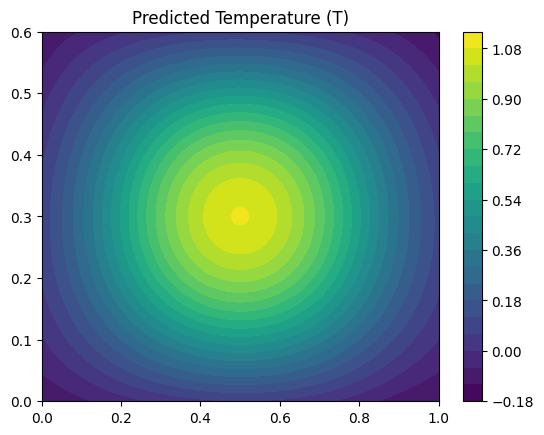

In [18]:
epochs = 5000
for epoch in range(epochs):
    loss = train_step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.4f}")

# Plot predicted temperature
T_pred = model(concatenate([X_tensor, Y_tensor], axis=1))
T_pred = tf.reshape(T_pred, (N, N)).numpy()

plt.figure()
plt.contourf(X, Y, T_pred, levels=20)
plt.colorbar()
plt.title("Predicted Temperature (T)")
plt.show()